# HW


> 설명

다음은 tensorflow 에서 제공하는 pre-trained 모델들이다.

https://keras.io/api/applications/

ResNet50v2 모델은 수업에서 설명한 ResNet 모델에서 BatchNormalization 과 ReLu 의 순서를 변경하여 약간의 성능 이득을 달성한 버전이다.

<img src="https://www.researchgate.net/profile/Ngo-Le-Huy-Hien/publication/342334669/figure/fig2/AS:904483026513920@1592656966286/A-comparison-between-ResNet-v1-and-ResNet-v2-on-residual-blocks-23.ppm" width=400 />



> 문제

ResNet50v2 모델을 이용하여 Cifar10 데이터셋을 분류하는 모델을 Transfer Learning 방법으로 구현하시오. 

* model.summary() 로 결과를 출력하시오.
* epoch 1 로 모델을 학습하여 정확도를 출력하시오.
* HINT: 교재 p405 를 참고하시오.

> 제출

PLATO "(평가) 실습 과제 제출 게시판"에 Colab > 파일 > 다운로드 .ipynb 한 파일을 비밀글로 제출하시오.


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image # pip install pillow

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
#2
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')      # (50000, 32, 32, 3)
x_test = x_test.astype('float32')        # (10000, 32, 32, 3)

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
# one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
# preprocessing, 'caffe', x_train, x_test: BGR
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [6]:
#3: resize_layer
inputs = Input(shape = (32, 32, 3))
resize_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img,(224, 224)))(inputs)
res_model = ResNet50V2(weights = 'imagenet', include_top = False, input_tensor = resize_layer)
res_model.trainable=False

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# tf.keras.applications.ResNet50V2(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

In [7]:
#4: create top for cifar10 classification
x = res_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
outs  = Dense(10, activation = 'softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs=outs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                             

In [16]:
#5: train and evaluate the model
# epochs = 1 : accuracy : 0.18
# epochs = 5 : accuracy : 0.22
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
ret = model.fit(x_train, y_train, epochs = 10, batch_size = 64, validation_split = 0.3, verbose = 1) #, callbacks = [cp_callback])

Epoch 1/10
547/547 [==============================] - 120s 213ms/step - loss: 2.0848 - accuracy: 0.2266 - val_loss: 2.0055 - val_accuracy: 0.2359
Epoch 2/10
547/547 [==============================] - 124s 226ms/step - loss: 2.0536 - accuracy: 0.2345 - val_loss: 1.9865 - val_accuracy: 0.2381
Epoch 3/10
547/547 [==============================] - 124s 227ms/step - loss: 2.0144 - accuracy: 0.2393 - val_loss: 2.0361 - val_accuracy: 0.2161
Epoch 4/10
547/547 [==============================] - 118s 215ms/step - loss: 2.0111 - accuracy: 0.2385 - val_loss: 2.0584 - val_accuracy: 0.2345
Epoch 5/10
547/547 [==============================] - 124s 227ms/step - loss: 2.0013 - accuracy: 0.2429 - val_loss: 1.9390 - val_accuracy: 0.2636
Epoch 6/10
547/547 [==============================] - 124s 227ms/step - loss: 1.9947 - accuracy: 0.2484 - val_loss: 1.9301 - val_accuracy: 0.2713
Epoch 7/10
547/547 [==============================] - 124s 227ms/step - loss: 1.9852 - accuracy: 0.2473 - val_loss: 2.0199 -

In [17]:
y_pred = model.predict(x_train)
y_label = np.argmax(y_pred, axis = 1)
C = tf.math.confusion_matrix(np.argmax(y_train, axis = 1), y_label)
print("confusion_matrix(C):", C)

1563/1563 [==============================] - 117s 75ms/step
confusion_matrix(C): tf.Tensor(
[[  47  341  210   78   10    1   64    0 3953  296]
 [   0 2284   10   28    9    0   51    0 1715  903]
 [  65 1286  536  789   86    5  552    0 1275  406]
 [  22 1317  358 1631  108    3  735    0  456  370]
 [   9 1790  302  780   87    2  772    0  779  479]
 [  10 1028  419 2132   89    6  674    0  366  276]
 [   4 2560  217  652   94    0  745    0  297  431]
 [  10 1658  272 1135   97    1  788    0  540  499]
 [   2  274   27   26    7    0   20    0 4361  283]
 [   0 2046   22   27   14    0   65    0 1892  934]], shape=(10, 10), dtype=int32)


In [18]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose = 1)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 1)

313/313 [==============================] - 25s 81ms/step - loss: 2.0770 - accuracy: 0.2133


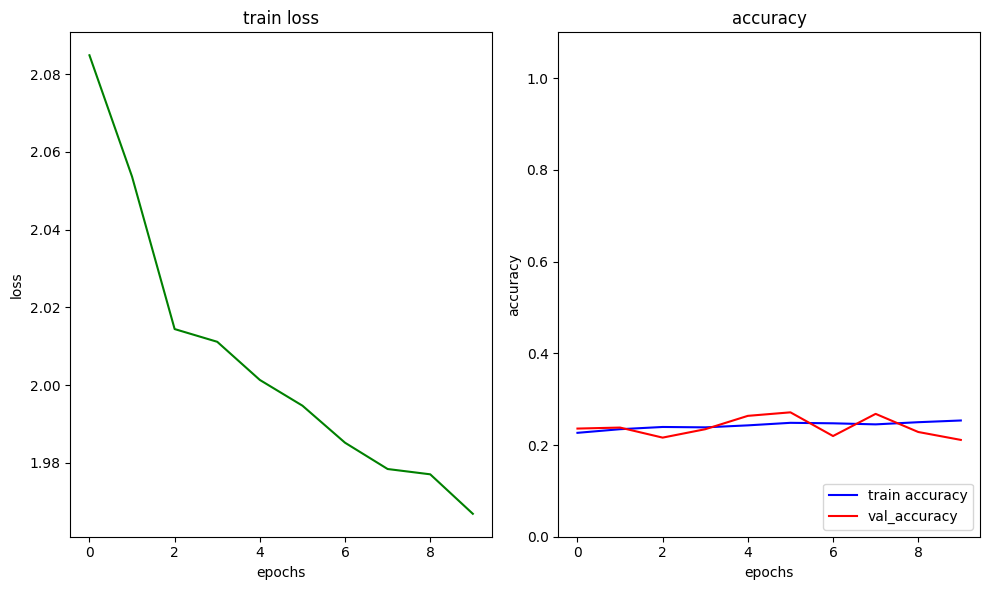

In [19]:
#6: plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(ret.history['loss'], "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].set_ylim(0, 1.1)
ax[1].plot(ret.history['accuracy'], "b-", label = "train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label = "val_accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc = 'lower right')
fig.tight_layout()
plt.show()